In [1]:
import numpy as np
import json
import torch
import random
import time
import matplotlib.pyplot as plt

c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Task 1

In [2]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [3]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test')  # <-- Why test? See next slides for an answer!

## [Task 2] Train, Validation and Test splits

CoQA only provides a train and validation set since the test set is hidden for evaluation purposes.

We'll consider the provided validation set as a test set. <br>
$\rightarrow$ Write your own script to:
* Split the train data in train and validation splits (80% train and 20% val)
* Perform splits such that a dialogue appears in one split only! (i.e., split at dialogue level)
* Perform splitting using the following seed for reproducibility: 42

#### Reproducibility Memo

Check back tutorial 2 on how to fix a specific random seed for reproducibility!

In [4]:
with open(os.path.join('coqa', 'train.json'), 'r') as j:
    train = json.loads(j.read())

with open(os.path.join('coqa', 'test.json'), 'r') as j:
    test = json.loads(j.read())

In [5]:
train = train['data']
test = test['data']

for t in train:
    indices = [i for i, a in enumerate(t['answers']) if a['input_text'] != 'unknown']
    t['questions'] = [q for i, q in enumerate(t['questions']) if i in indices] 
    t['answers'] = [a for i, a in enumerate(t['answers']) if i in indices]

# TODO DO THE SAME FOR TEST

#train_answer_indices = [[i for i, a in enumerate(t.answers) if a.input_text != 'unknown'] for t in train]
#test_answer_indices = [[i for i, a in enumerate(t.answers) if a.input_text != 'unknown'] for t in test]



In [6]:
lengths=[len(doc['questions']) for doc in train]

In [7]:
le=np.cumsum(np.array(lengths,dtype=np.float32))
train_end=np.where((le/le[-1])>0.8)[0][0]

validation = train[train_end :] 
train = train[ : train_end]

In [8]:
print(len(train))
print(len(validation))

5773
1426


In [9]:
len_train=np.sum([len(doc['questions']) for doc in train])
len_val=np.sum([len(doc['questions']) for doc in validation])

len_tot=len_train+len_val
print(len_train,len_train/len_tot)
print(len_val,len_val/len_tot)

85810 0.7998993251053358
21466 0.20010067489466424


In [10]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, data, return_history=False):

        self.story=[d['story'] for d in data]
        self.questions=[d['questions'] for d in data]
        self.answers=[d['answers'] for d in data]
        lengths = [len(doc['questions']) for doc in data]
        self.lengths = np.cumsum(np.array(lengths,dtype=np.int32))
        self.R_H=return_history
        

    def __len__(self):
        return self.lengths[-1]

    def __getitem__(self, idx):
        f_idx=int(np.where(self.lengths > idx)[0][0])
        if f_idx>0:
            q_idx=idx-self.lengths[f_idx-1]
        else:
            q_idx=idx

        passage=self.story[f_idx]
        questions=self.questions[f_idx]
        answers=self.answers[f_idx]
        question=questions[q_idx]['input_text']
        span_start=int(answers[q_idx]['span_start'])
        span_end=int(answers[q_idx]['span_end'])
        span_text=answers[q_idx]['span_text']

        if self.R_H:
            history = np.concatenate([ [questions[i]['input_text'], answers[i]['input_text']] for i in range(q_idx)],0)
            return (passage,question,history), (span_start,span_end)

        return (passage,question), (span_start,span_end)

In [11]:
'''# target is "nice puppet"
target_start_index = torch.tensor([14])
target_end_index = torch.tensor([15])



outputs = model(**inputs, start_positions=target_start_index, end_positions=target_end_index)
loss = outputs.loss
round(loss.item(), 2)''';

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(CustomImageDataset(train), batch_size=64, shuffle=False)
val_dataloader = DataLoader(CustomImageDataset(validation), batch_size=64, shuffle=True)
test_dataloader = DataLoader(CustomImageDataset(test), batch_size=64, shuffle=True)

# Task 3

## [Task 3] Model definition

Write your own script to define the following transformer-based models from [huggingface](https://HuggingFace.co/).

* [M1] DistilRoBERTa (distilberta-base)
* [M2] BERTTiny (bert-tiny)

**Note**: Remember to install the ```transformers``` python package!

**Note**: We consider small transformer models for computational reasons!

In [13]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

model_name = 'distilroberta-base'

M1 = AutoModelForQuestionAnswering.from_pretrained(model_name)
T1 = AutoTokenizer.from_pretrained(model_name, max_new_tokens=50)

model_name = 'prajjwal1/bert-tiny'

M2 = AutoModelForQuestionAnswering.from_pretrained(model_name)
T2 = AutoTokenizer.from_pretrained(model_name, max_new_tokens=50)


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForQuestionAnswering: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be 

In [14]:
def get_target_indices(inputs,sep_starts, sep_ends):
    start_positions = []
    end_positions = []

    for i, offset in enumerate(inputs["offset_mapping"]):
        sample_idx = inputs["overflow_to_sample_mapping"][i]
        start_char = sep_starts[sample_idx]
        end_char = sep_ends[sample_idx]
        sequence_ids = inputs.sequence_ids(i)


        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    return start_positions, end_positions

In [15]:
def encode(tokenizer, questions, passages, max_length=100, stride=50):
        return tokenizer(
            questions,
            passages,
            max_length=max_length,
            truncation="only_second",
            stride=stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length", 
            return_tensors="pt"
        )

In [16]:
def train(model, tokenizer, epochs=1, learning_rate=1e-3):
    
    model.to('cuda')

    loss_history=[]

    model.config.decoder_start_token_id = tokenizer.cls_token_id
    model.config.pad_token_id = tokenizer.pad_token_id

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    max_length = 500
    stride=30
    
    start_time = time.time()
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for batch_idx, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            (passage, question), (sep_starts, sep_ends) = data

            #text_input = [question[i] + ' [SEP] ' + passage[i] for i in range(len(passage))]

            # zero the parameter gradients
            optimizer.zero_grad()
            
            try:
                inputs = encode(tokenizer, question, passage, max_length=max_length, stride=stride)
            except:
                inputs = encode(tokenizer, question, passage, max_length=max_length*2, stride=stride)

            start_positions, end_positions= get_target_indices(inputs, sep_starts, sep_ends)

            target_start_index = torch.tensor(start_positions)[inputs['overflow_to_sample_mapping']].to('cuda')
            target_end_index = torch.tensor(end_positions)[inputs['overflow_to_sample_mapping']].to('cuda')

            del inputs['overflow_to_sample_mapping']
            del inputs['offset_mapping']

            outputs = model(**inputs.to('cuda'), start_positions=target_start_index, end_positions=target_end_index)

            loss = outputs.loss
            loss.backward()

            optimizer.step()

            # print statistics
            running_loss += loss.item()

            loss_history.append(loss.detach().cpu().numpy())
            
            epoch_time = time.time() - start_time
            batch_time = epoch_time/(batch_idx+1)

            print(f"epoch: {epoch + 1}/{epochs}, {batch_idx + 1}/{len(train_dataloader)}, {epoch_time:.0f}s {batch_time*1e3:.0f}ms/step, lr: {optimizer.param_groups[0]['lr']:.3g}, loss: {running_loss/(batch_idx+1):.3g}", end = '\r')

        print(f"epoch: {epoch + 1}/{epochs}, {batch_idx + 1}/{len(train_dataloader)}, {epoch_time:.0f}s {batch_time*1e3:.0f}ms/step, lr: {optimizer.param_groups[0]['lr']:.3g}, loss: {running_loss/(batch_idx+1):.3g}")

    return loss_history

In [17]:
R=[]    # save history of the runs

In [18]:
LR=[5e-5]  # lr to test         [1e-2,1e-3,1e-4,1e-5]

for lr in LR:
    M2 = AutoModelForQuestionAnswering.from_pretrained(model_name)
    H=train(M2,T2,epochs=3,learning_rate=lr)
    R.append([H,lr])

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model

epoch: 1/3, 1341/1341, 394s 294ms/step, lr: 5e-05, loss: 4.86
epoch: 2/3, 1341/1341, 778s 580ms/step, lr: 5e-05, loss: 4.31
epoch: 3/3, 1341/1341, 1167s 871ms/step, lr: 5e-05, loss: 4.047


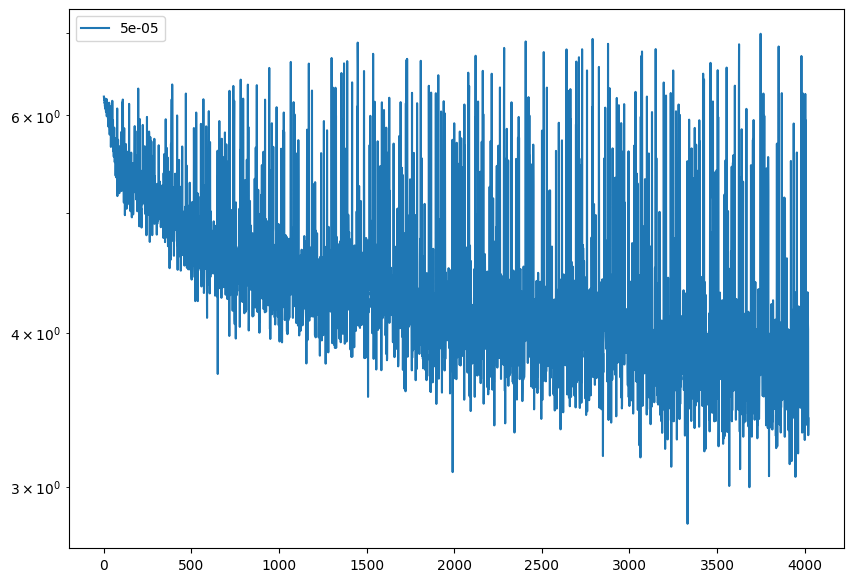

In [19]:
plt.figure(figsize=(10,7))
for r in R:
    plt.plot(r[0])
plt.yscale('log')
plt.legend([r[1] for r in R])


In [20]:
tokenizer=T2
model=M2

max_length=100
stride=50


for i, data in enumerate(val_dataloader, 0):
    if i>0:
        break

    (passage, question), (sep_starts, sep_ends) = data
    inputs = encode(tokenizer, question, passage, max_length=max_length, stride=stride)

    start_positions, end_positions= get_target_indices(inputs, sep_starts, sep_ends)

    target_start_index = torch.tensor(start_positions)[inputs['overflow_to_sample_mapping']].to('cuda')
    target_end_index = torch.tensor(end_positions)[inputs['overflow_to_sample_mapping']].to('cuda')

    del inputs['overflow_to_sample_mapping']
    del inputs['offset_mapping']


    outputs = model(**inputs.to('cuda'), start_positions=target_start_index, end_positions=target_end_index)

    print(np.argmax(outputs.start_logits.detach().cpu(),1))
    print(np.argmax(outputs.end_logits.detach().cpu(),1))
    print()
    print(outputs.start_logits.detach().cpu()[0])
    print(outputs.loss)

tensor([25,  0,  0, 47,  0,  0,  0, 85, 71, 88, 47, 43,  0, 67, 26,  0,  0,  0,
         0,  0,  0,  0, 67, 85, 56, 16,  0, 46, 80, 38, 78, 69, 14,  0,  0,  0,
         0,  0,  0,  0, 75, 31,  0, 84,  0, 92, 54,  0,  0, 78, 65, 27,  0, 83,
         0,  0,  0,  0,  0,  7, 83,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, 32,  0,  0,  0,  0,  0,  0,  0,  0, 32,  0,  0,  0,  0,
        46,  0,  0, 29, 20, 83, 41,  0,  0, 44,  0, 49, 95, 50, 31,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, 91, 50,  0, 68, 25, 56, 12, 95, 52, 57,
         5,  0,  0,  0,  0,  0,  0,  0,  0,  0, 59, 18, 22, 71,  0,  8,  0,  0,
        44, 60, 18,  0, 85,  0,  0,  0,  0, 57, 18, 72, 33, 48, 69, 20,  0, 95,
        53, 11,  0,  0,  0, 70, 83, 49, 15,  0, 45,  0,  0,  0,  0,  0, 66, 28,
        39,  0,  0, 33,  0,  0,  0,  7, 66, 24,  7, 37,  8, 13,  0,  0,  0,  0,
        60,  8, 85, 43,  0, 90,  0,  0,  0,  0,  0, 19, 84, 44, 10,  8,  0,  0,
         0,  0, 60, 19,  0,  0, 13,  0, 